In [49]:
from datasets import load_dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, vq
from numpy.linalg import norm

In [2]:
dataset = load_dataset('frgfm/imagenette',
                       'full_size')

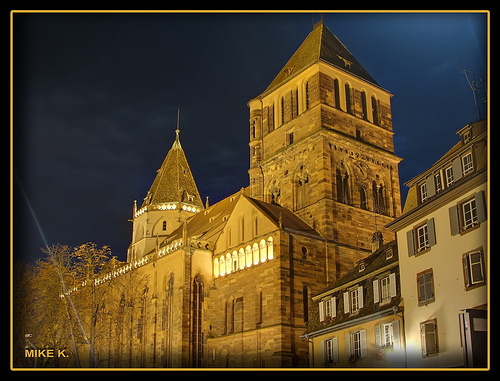

In [3]:
dataset['train'][3265]['image']

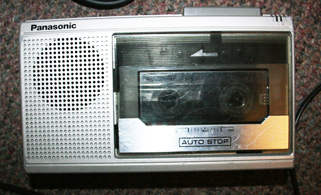

In [4]:
dataset['train'][304]['image']

In [5]:
images_nparrays = [np.array(dataset['train'][n]['image']) for n in range(len(dataset['train']))]

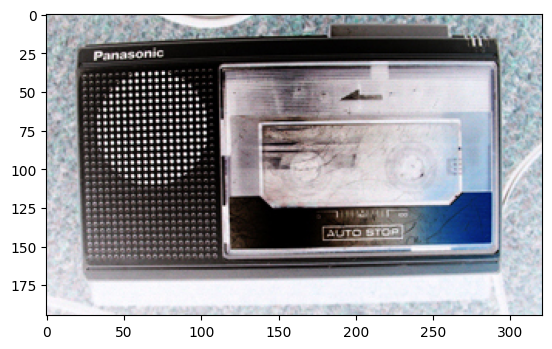

In [71]:
plt.imshow(255 - images_nparrays[304])

In [6]:
print('Image types are:', np.unique([len(img.shape) for img in images_nparrays]))

Image types are: [2 3]


In [7]:
images_gs = []
for img in images_nparrays:
    if img.shape[-1] == 3:
        images_gs.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        images_gs.append(img)

# Visual Features

In [8]:
extractor = cv2.xfeatures2d.SIFT_create()

keypoints = []
descriptors = []

for img in images_gs:
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

[ WARN:0@17.933] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


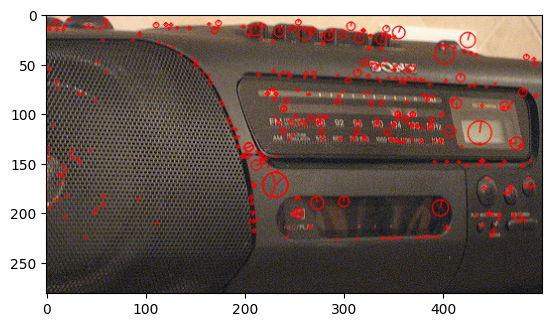

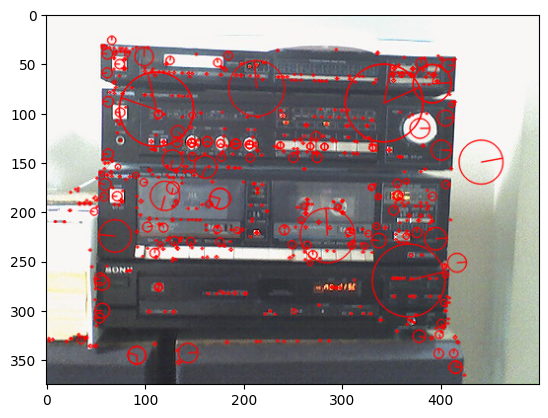

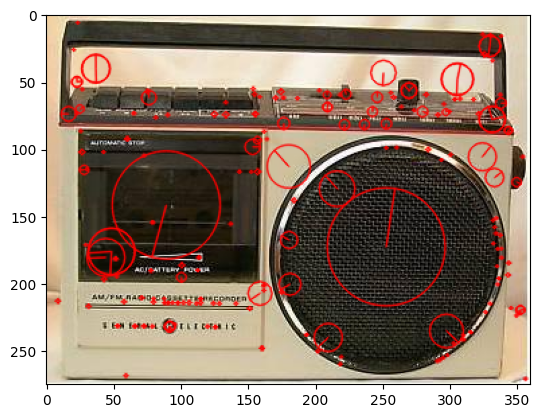

In [77]:
output_image = []
for x in range(3):
    output_image.append(cv2.drawKeypoints(images_nparrays[x],keypoints[x], 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()

# Visual Words and the Codebook

In [33]:
np.random.seed(0)
sample_idx = np.random.randint(0, len(dataset['train']) + 1, 1000).tolist()

descriptors_sample = []

for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))

In [34]:
all_descriptors = [descriptor for img_descriptors in descriptors_sample for descriptor in img_descriptors]

all_descriptors = np.stack(all_descriptors)

In [35]:
k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)

In [36]:
visual_words = []
for img_descriptors in descriptors:
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [37]:
visual_words[0][:5], len(visual_words[0])

(array([134,  32,  63,  51,  51], dtype=int32), 397)

# Sparse Frequency Vectors

In [38]:
frequency_vectors = []

for img_visual_words in visual_words:
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
    
frequency_vectors = np.stack(frequency_vectors)

In [39]:
frequency_vectors.shape

(9469, 200)

In [40]:
for i in [84, 22, 45, 172]:
    print(f"{i}: {frequency_vectors[0][i]}")

84: 0.0
22: 12.0
45: 0.0
172: 3.0


In [41]:
frequency_vectors[0][:20]

array([ 2.,  0.,  1.,  3.,  0.,  2.,  0.,  0.,  1.,  1.,  3.,  0.,  0.,
        0., 12.,  3.,  0.,  0.,  0.,  0.])

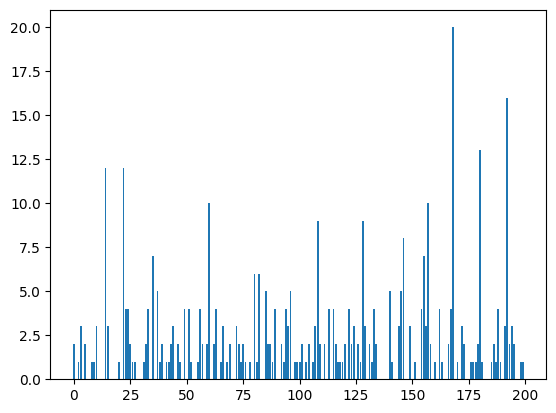

In [42]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

# Term Frequency - Inverse Document Frequency

In [44]:
N = len(dataset['train'])

df = np.sum(frequency_vectors > 0, axis=0)

In [45]:
df.shape, df[:5]

((200,), array([7363, 7946, 7638, 8068, 8138]))

In [46]:
idf = np.log(N / df)
idf.shape, idf[:5]

((200,), array([0.25155585, 0.17535465, 0.21488752, 0.16011768, 0.15147886]))

In [47]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[0][:5]

((9469, 200),
 array([0.50311169, 0.        , 0.21488752, 0.48035305, 0.        ]))

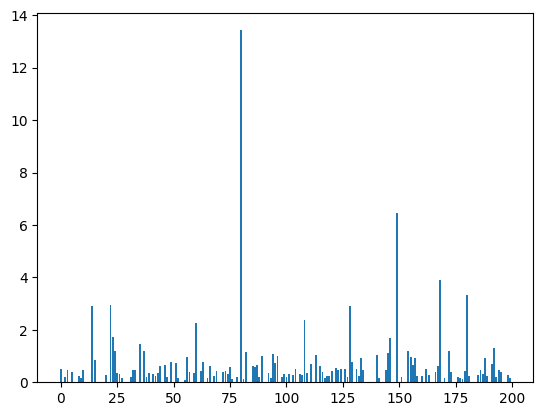

In [48]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

# Search

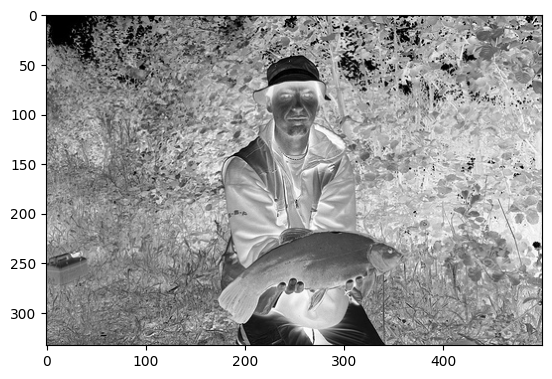

In [78]:
plt.imshow(255 - images_gs[1200], cmap='gray')
plt.show()

1200: 1.0


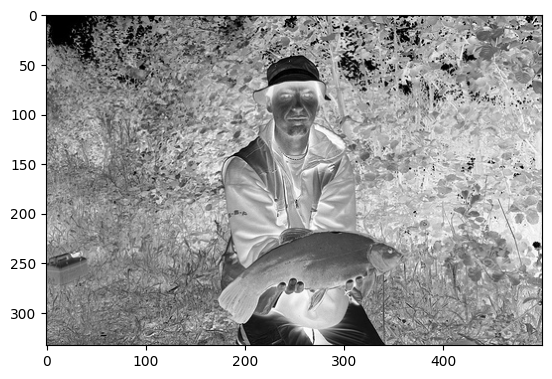

1739: 0.942


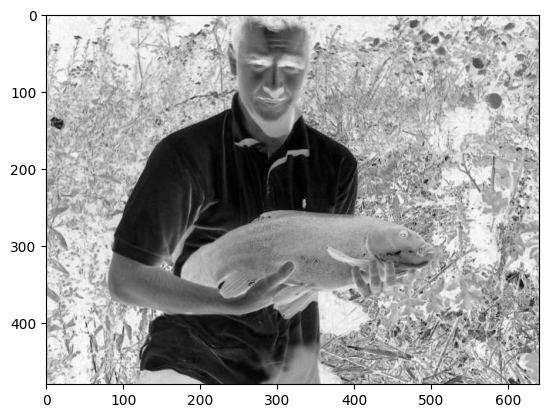

1609: 0.9396


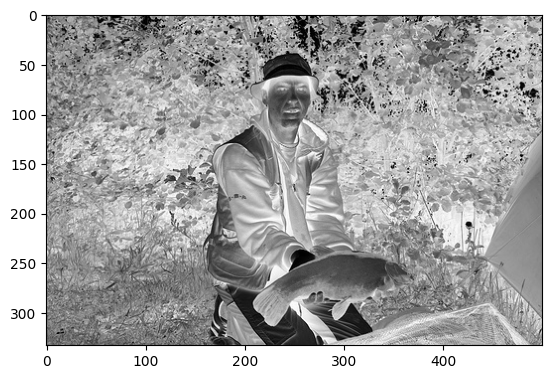

7457: 0.9329


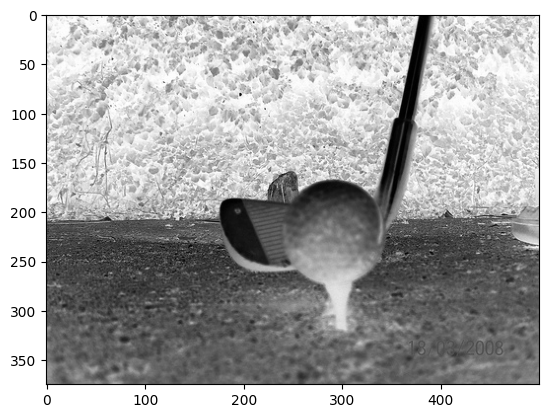

1070: 0.9328


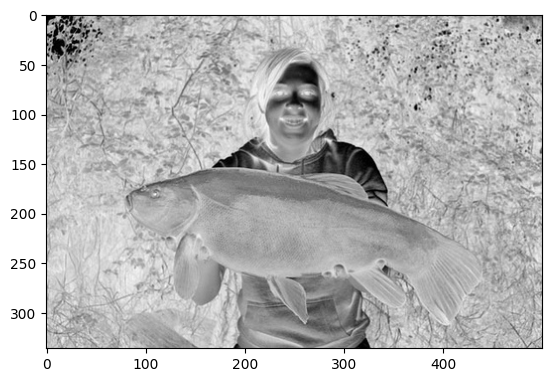

In [79]:
top_k = 5
i = 1200

a = tfidf[i]
b = tfidf

cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))
idx = np.argsort(-cosine_similarity)[:top_k]

for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)}")
    plt.imshow(255 - images_gs[i], cmap='gray')
    plt.show()